# Coupled Transmon / LC-oscillator (using the GUI)

In [1]:
import numpy as np

# Import the graphical user interface
from Qcircuits import GUI

# For the purpose of this tutorial, 
# we create a file describing the circuit
# which would typically done by the user
# from a blank editor
import os
os.makedirs('circuits/', exist_ok=True)
with open('circuits/transmon_LC_GUI.txt','w') as f:
    f.write("""C;0,-1;1,-1;1.000000e-15;
C;-1,0;-1,-1;1.000000e-13;
J;0,0;0,-1;;L_J
W;-1,0;0,0;;
W;-1,-1;0,-1;;
C;1,0;1,-1;1.000000e-13;
L;2,0;2,-1;1.000000e-08;
W;1,0;2,0;;
W;1,-1;2,-1;;
G;2,1;2,0;;
G;-1,1;-1,0;;
R;3,0;3,-1;1.000000e+06;
W;2,0;3,0;;
W;2,-1;3,-1;;
""")

## Construct the circuit

We will be studying a circuit constituted of a transmon qubit coupled to a lossy RLC resonator.

Below we open the editor. All changes made to the circuit are saved automatically and when we shut down the editor, the variable ``cir`` here will become a quantum circuit object ``Qcircuits.Qcircuit`` with which we will analyze the circuit.

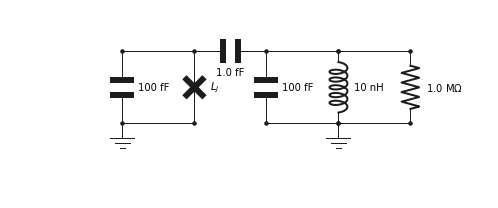

C 1 2 1.0 fF
C 0 1 100 fF
J 0 1 L_J
C 0 2 100 fF
L 0 2 10 nH
R 0 2 1.0 MOhm




In [2]:
cir = GUI('circuits/transmon_LC_GUI.txt', # location of the circuit file
        edit=True, # open the GUI to edit the circuit
        plot=True, # plot the circuit after having edited it
        print_network=True # print the network
       )

Notice that the junction does not have a value 
here but a symbolic label ``L_J``.
This is because in this example, 
we wish to sweep its value.

The most computationally expensive part of the 
analysis is performed upon initializing the circuit. 
To avoid doing at each iteration of our sweep, 
we have the option to enter a symbolic value for a component.
    
Its value can then be passed
as a keyword argument in subsequent function calls ``L_J=1e-9``. 

## Circuit parameters

We now calculate the eigenfrequency, loss-rates, anharmonicity, and Kerr parameters of the circuit. 

This can be done through the functions ``eigenfrequencies``, ``loss_rates``, ``anharmonicities`` and ``kerr``, which return the specified quantities for each mode, **ordered with increasing mode frequency**.

These quantities are plotted below for a varying Josephson inductance.

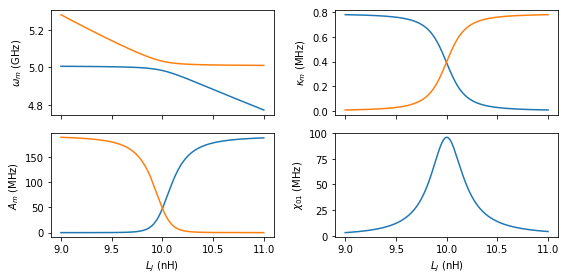

In [3]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of plots
fig,ax = plt.subplots(2,2,sharex = True,figsize = (8,4))

# Here we specify the values the junction inductance should take
L_J = np.linspace(11e-9,9e-9, 1001)

ax[0][0].plot(L_J*1e9,[cir.eigenfrequencies(L_J = x)/1e9 for x in L_J])
ax[0][0].set_ylabel('$\omega_m$ (GHz)')


ax[0][1].plot(L_J*1e9,[cir.loss_rates(L_J = x)/1e6 for x in L_J])
ax[0][1].set_ylabel('$\kappa_m$ (MHz)')

ax[1][0].plot(L_J*1e9,[cir.anharmonicities(L_J = x)/1e6 for x in L_J])
ax[1][0].set_ylabel('$A_m$ (MHz)')

# the components ``K[i,j]`` of the matrix returned by the kerr function
# corresponds to the cross-Kerr interaction of mode ``i`` with mode ``j``
ax[1][1].plot(L_J*1e9,[cir.kerr(L_J = x)[0,1]/1e6 for x in L_J])
ax[1][1].set_ylabel('$\chi_{01}$ (MHz)')

ax[1][0].set_xlabel('$L_J$ (nH)')
ax[1][1].set_xlabel('$L_J$ (nH)')

plt.tight_layout()
plt.show()

Alternatively, we can obtain all these parameters at once for a given value of the junction inductance

In [19]:
cir.f_k_A_chi(L_J=1e-8)

(array([4.98333767e+09, 5.03291805e+09]),
 array([390085.6448015 , 397887.35776132]),
 array([47500085.74918161, 48449966.18128259]),
 array([[47500085.74918161, 95945350.03127295],
        [95945350.03127295, 48449966.18128259]]))

and print them in a pretty way

In [20]:
f,k,A,chi = cir.f_k_A_chi(L_J=1e-8,pretty_print = True)

    mode |  freq.  |  diss.  |  anha.  |
       0 | 5.0 GHz | 390 kHz |  48 MHz |
       1 | 5.0 GHz | 398 kHz |  48 MHz |

Kerr coefficients
(diagonal = Kerr, off-diagonal = cross-Kerr)
    mode |    0    |    1    |
       0 |  48 MHz |         |
       1 |  96 MHz |  48 MHz |



## Visualizing normal modes

We now concentrate on the resonance point, when the normal mode splitting occurs ``L_J = 10e-9``

We use the ``show_normal_mode`` method to visualize the two different modes.

The size and annotation of the arrows corresponds to the contribution of the mode to the zero-point fluctuations in current $i_\text{zpf,m}$, such that the operator for the total current entering a component is

$\hat{i} = \sum_m i_\text{zpf,m}(\hat{a}_m+\hat{a}_m^\dagger)$

where $\hat{a}_m$ is the annihilation operator of mode $m$.

The relative direction of the arrows is given by the direction current would flow through that component if mode $m$ was in a coherent state.

By changing the parameter ``quantity``, we show the value of other zero-point fluctuations, and we can enter ``'voltage'``, ``'charge'``, or ``'flux'``. The direction of the arrows however, always represent the current.

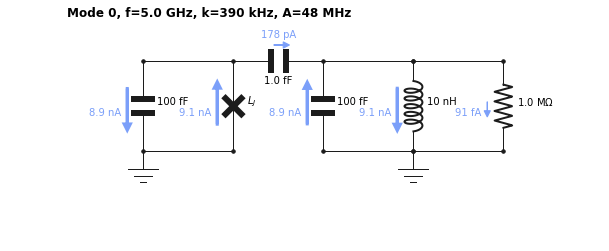

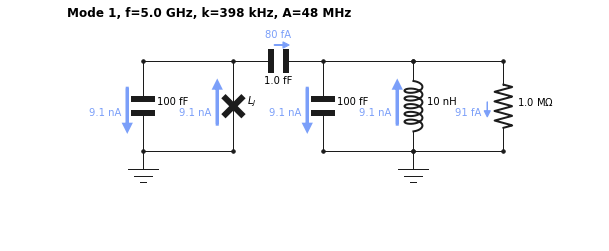

In [4]:
cir.show_normal_mode(mode=0,quantity='current', L_J = 10e-9)
cir.show_normal_mode(mode=1,quantity='current', L_J = 10e-9)

We see above that the symmetry on each side of the coupling capacitor is changing between the modes, the above is called the anti-symmetric mode, with a voltage build-up on either side of the coupling capacitor leading to a current going through it. Mode 1 is the anti-symmetric mode.

These zero-point fluctuations can also be accessed programmatically in the case we build the circuit with the Network function, see below:

In [5]:
# Import the circuit builder
from Qcircuits import Network
# Import the circuit components
from Qcircuits import L,J,C,R

# create the coupling capacitor seperately, 
# enabling us to interact with it afterwards
coupling_capacitor = C(1,2,1e-15)

# construct the circuit
cir_net = Network([
    C(0,1,100e-15),
    J(0,1,10e-9),
    coupling_capacitor,
    C(2,0,100e-15),
    L(2,0,10e-9),
    R(2,0,1e6)
])

In [6]:
cir_net.eigenfrequencies()[0]/1e9

4.983337670035195

Which is lower due a higher zero-point voltage fluctuation across the coupling capacitor

In [7]:
coupling_capacitor.zpf(mode = 0, quantity = 'voltage')

-5.687865667318499e-06j

Compared to the symmetric mode with frequency:

In [8]:
cir_net.eigenfrequencies()[1]/1e9

5.0329180489473675

And zero-point voltage fluctuation across the coupling capacitor

In [9]:
coupling_capacitor.zpf(mode = 1, quantity = 'voltage')

-2.5231302064585313e-09j

## Further analysis in QuTiP

The Hamiltonian of the circuit, with the non-linearity of the Josephson junctions
Taylor-expanded, is given by

$\hat{H} = \sum_{m\in\text{modes}} hf_m\hat{a}_m^\dagger\hat{a}_m +\sum_j\sum_{2n\le\text{taylor}}E_j\frac{(-1)^{n+1}}{(2n)!}\left(\frac{\phi_{zpf,m,j}}{\phi_0}(\hat{a}_m^\dagger+\hat{a}_m)\right)^{2n}$

And in its construction, we have the freedom to choose the set of ``modes`` to include, the order of the Taylor expansion of the junction potential, and the number of excitations of each mode to consider.

We will use the diagonalization of the hamiltonian to produce the evolution of two first transition frequencies of the system as a function of ``L_J``

In [51]:
eigen_energies = []
L_J = np.linspace(10e-9,8e-9, 101)
for x in L_J:
    # Note that we could use either ``cir`` or the circuit built above ``cir_net``
    H = cir.hamiltonian(modes = [0,1],taylor = 8,excitations = [10,10], L_J = x)
    eigen_energies.append(H.eigenenergies())
eigen_energies = np.absolute(eigen_energies)

We can for example compare the size of the avoided crossing computed from a diagonalization of the Hamiltonian (usually called the vacuum-Rabi splitting), with that calculated from a normal mode analysis (called normal-mode splitting)

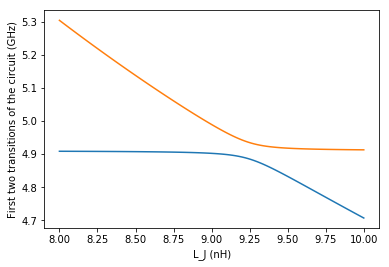

In [52]:
first_transition = (eigen_energies[:,1]-eigen_energies[:,0])
second_transition = (eigen_energies[:,2]-eigen_energies[:,0])

plt.plot(L_J*1e9,first_transition/1e9)
plt.plot(L_J*1e9,second_transition/1e9)
plt.xlabel('L_J (nH)')
plt.ylabel('First two transitions of the circuit (GHz)')
plt.show()

Note that the splitting does not occur at 10nH anymore. This is because the Transmon "bare" frequency is shifted by the quantum fluctuations through the junctions.

However, the magnitude of the frequency spliting that occurs is approximately the same and can be predicted without recourse to a Hamiltonian diagonalization. This splitting is also twice the coupling $g$ that one would use when formulating this problem in the context of the Rabi or Jaynes-Cummings Hamiltonian.

In [54]:
rabi_splitting = min(second_transition-first_transition)/1e6
mode_splitting = (cir.eigenfrequencies(L_J=10e-9)[1]-cir.eigenfrequencies(L_J=10e-9)[0])/1e6

print("Quantum calculation -- Rabi splitting is %.2f MHz"%rabi_splitting)
print("Classical calculation -- normal-mode splitting is %.2f MHz"%mode_splitting)

Quantum calculation -- Rabi splitting is 49.66 MHz
Classical calculation -- normal-mode splitting is 49.58 MHz
